<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

> Experiments with normalizations for Classifier-free Guidance.   

In [ ]:
#| echo: false

In [ ]:
#| echo: false
import matplotlib.pyplot as plt

# Introduction

This notebook is Part 2 in a [series](https://enzokro.dev/blog/posts/2022-11-15-guidance-expts-2/) on dynamic Classifier-free Guidance.  

## Quick recap of Part 1
In Part 1, we generated a baseline image using the default, static Classifier-free Guidance. To see if we could improve on the baseline, we swept a range of Cosine Schedules on the guidance parameter $G$.  

To recap the results of the sweep, there are a few promising guidance schedules to explore:  

- Setting a higher guidance value.  
- Allowing the Cosine schedule to go through multiple cycles.  
- Warming up the guidance for a few steps. 

## Part 2: Bringing in Normalizations

In Part 2, we bring in normalizations as another kind of dynamic guidance.  

The idea is that normalizing the guidance might improve the updates in the Diffusion model's latent image space. To test this we explore three kinds of guidance normalizations:  

1. Normalizing the prediction by its overall norm.  
2. Normalizing the guidance update vector, $\left(t - u\right)$, by its norm.  
3. Combining the Normalizations in `1.` and `2.`  

:::: {.callout-note}  
More details about the normalizations can be found in [this section](https://enzokro.dev/blog/posts/2022-11-15-guidance-expts-1/#normalizing-the-guidance) of the original post.  
::::

After these runs, we should have a good idea of both the schedules and normalizations that can improve Diffusion images. We will then combine the two approaches and explore other, more advanced schedules.

## Leveraging a few helper libraries

We use two new libraries that make it easier to run dynamic Classifier-free Guidances.\
These two libraries are:

- `min_diffusion`
- `cf_guidance`

The helper libraries remove a lot of overhead and boilerplate code. They allow us to jump straight to the important parts: running the guidance experiments.  

For more details, the libraries were introduced in [this earlier post](https://enzokro.dev/blog/posts/2022-11-20-minimal-diffusion/).  

# Experiment Setup

## Python Imports

To start we import the needed python modules.  

We also handle random seeding to make sure that our results are reproducible across the series.  

In [ ]:
import os
import math
import random
import warnings
from PIL import Image
from typing import List
from pathlib import Path
from types import SimpleNamespace
from fastcore.all import L

import numpy as np
import matplotlib.pyplot as plt

# imports for diffusion models
import torch
from transformers import logging
# for clean outputs
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

# seed for reproducibility
SEED = 1024
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    generator = torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return generator
# for sampling the initial, noisy latents
generator = seed_everything(SEED)

# set the hardware device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu"

2022-11-23 14:58:50.779076: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## The `min_diffusion` library

We use the `min_diffusion` library to load a Stable Diffusion model from the HuggingFace hub.  

In [ ]:
# to load Stable Diffusion pipelines
from min_diffusion.core import MinimalDiffusion

# helpers to plot the generated images
from min_diffusion.utils import show_image, image_grid

### Loading the `openjourney` model from Prompt Hero

The following code loads the `openjourney` model in `torch.float16` precision and puts it on the GPU.

In [ ]:
model_name = 'prompthero/openjourney'
device     = 'cuda'
dtype      = torch.float16

In [ ]:
pipeline = MinimalDiffusion(model_name, device, dtype)

In [ ]:
pipeline.load();

Enabling default unet attention slicing.


## Text prompt for generations

We use the familiar, running prompt in our series to generate an image:  

> "a photograph of an astronaut riding a horse"

:::: {.callout-important}  
The `openjourney` model was fine-tuned to create images in the style of [Midjourney v4](https://mezha.media/en/2022/11/11/midjourney-v4-is-an-incredible-new-version-of-the-ai-image-generator/).  

To enable this fine-tuned style, we need to add the keyword `"mdjrny-v4"` at the start of the prompt.  
::::

In [ ]:
# text prompt for image generations
prompt = "mdjrny-v4 style a photograph of an astronaut riding a horse"

## Image parameters

The images will be generated over $50$ diffusion steps. They will have a height and width of `512 x 512` pixels. 

In [ ]:
# the number of diffusion steps
num_steps = 50

# generated image dimensions
width, height = 512, 512

# The Baseline: Guidance with a constant $G =7.5$

First we create the baseline. Then we will check how a normalized, dynamic guidance changes the output.  

The baseline Classifier-free Guidance uses a static, constant update of $G = 7.5$.  

In [ ]:
from cf_guidance.transforms import GuidanceTfm, BaseNormGuidance, TNormGuidance, FullNormGuidance

In [ ]:
# create the baseline Classifier-free Guidance
baseline_run = {'max_val': [7.5]}

# parameters we are sweeping
baselines_names = sorted(list(baseline_run))
baseline_scheds = L()

# step through each parameter
for idx,name in enumerate(baselines_names):
    # step through each of its values
    for idj,val in enumerate(baseline_run[name]):

        # create the baseline experimeent
        expt = {
            'param_name': name,
            'val': val,
            'schedule': [val for _ in range(num_steps)]
        }
        # for plotting
        expt['title'] = f'Param: "{name}", val={val}'
        
        # add to the running list of experiments
        baseline_scheds.append(expt)

## Wrapper to run the experiments

The `run` function below generates images from a given prompt.  

It also takes an argument `guide_tfm` for the specific Guidance Transformation class that will guide the outputs. The `schedules` argument has the parameter values of $G$ at each diffusion timestep.  

In [ ]:
def run(prompt, schedules, guide_tfm=None, generator=None,
        show_each=False, test_run=False):
    """Runs a dynamic Classifier-free Guidance experiment. 
    
    Generates an image for the text `prompt` given all the values in `schedules`.
    Uses a Guidance Transformation class from the `cf_guidance` library.  
    Stores the output images with a matching title for plotting. 
    Optionally shows each image as its generated.
    If `test_run` is true, it runs a single schedule for testing. 
    """
    # store generated images and their title (the experiment name)
    images, titles = [], []
    
    # make sure we have a valid guidance transform
    assert guide_tfm
    print(f'Using Guidance Transform: {guide_tfm}')
    
    # optionally run a single test schedule
    if test_run:
        print(f'Running a single schedule for testing.')
        schedules = schedules[:1]
        

    # run all schedule experiments
    for i,s in enumerate(schedules):
        
        # parse out the title for the current run
        cur_title  = s['title']
        titles.append(cur_title)
        
        # create the guidance transformation 
        cur_sched = s['schedule']
        gtfm = guide_tfm({'g': cur_sched})
        
        print(f'Running experiment [{i+1} of {len(schedules)}]: {cur_title}...')
        img = pipeline.generate(prompt, gtfm, generator=generator)
        images.append(img)
        
        # optionally plot the image
        if show_each:
            show_image(img, scale=1)

    print('Done.')
    return {'images': images,
            'titles': titles,}

Let's create the baseline image. The hope is that our guidance changes will then improve on it.  

In [ ]:
baseline_res = run(prompt, baseline_scheds, guide_tfm=GuidanceTfm, generator=generator)

Using Guidance Transform: <class 'cf_guidance.transforms.GuidanceTfm'>
Running experiment [1 of 1]: Param: "max_val", val=7.5...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


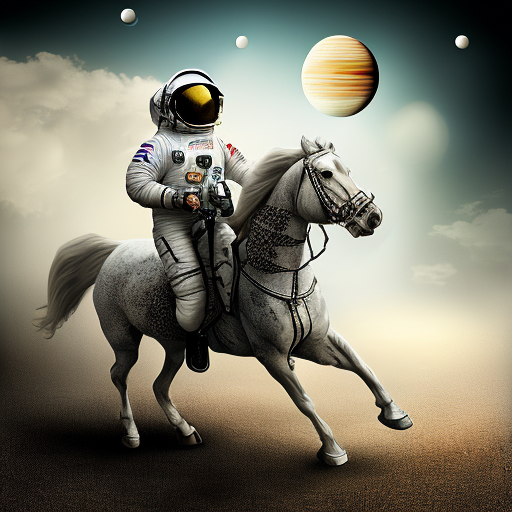

In [ ]:
# view the baseline image
baseline_res['images'][0]

Not a bad starting point. Let's see if we can do better.  

# Improving the baseline with normalizations

It seems that normalizations can improve both the syntax and details of Diffusion images.  

We explore three kinds of normalizations:  

1. `Prediction Normalization`  
2. `T-Normalization` 
3. `Full Normalization`  

## Details on normalized Guidance values

For `Prediction Normalization` we can use the same static $G = 7.5$ from the baseline.  

For both `T-Normalization` and `Full Normalization`, however, we need a much smaller guidance value. The reason is that these normalizations scale the update vector $\left( t - u \right)$ itself. That means that a large value like $G = 7.5$ would de-scale the vectors even more! That is the exact situation we are trying to avoid with normalization in the first place.  

To prevent this, we create a special $G_\text{small}$ schedule for T and Full Normalizations with a smaller value of $G_\text{small} = 0.15$

In [ ]:
# create the baseline Classifier-free Guidance
T_run = {'max_val': [0.15]}

# parameters we are sweeping
T_scheds = L()

# step through each parameter
for idx,name in enumerate(baselines_names):
    # step through each of its values
    for idj,val in enumerate(T_run[name]):

        # create the baseline experimeent
        expt = {
            'param_name': name,
            'val': val,
            'schedule': [val for _ in range(num_steps)]
        }
        # for plotting
        expt['title'] = f'Param: "{name}", val={val}'
        
        # add to the running list of experiments
        T_scheds.append(expt)

## `Prediction Norm` runs

In [ ]:
print('Running the BaseNorm experiments...')
base_norm_res = run(prompt, baseline_scheds, guide_tfm=BaseNormGuidance, generator=generator)

Running the BaseNorm experiments...
Using Guidance Transform: <class 'cf_guidance.transforms.BaseNormGuidance'>
Running experiment [1 of 1]: Param: "max_val", val=7.5...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


## `T-Norm` runs

In [ ]:
print('Running the T-Norm experiments...')
t_norm_res = run(prompt, T_scheds, guide_tfm=TNormGuidance, generator=generator)

Running the T-Norm experiments...
Using Guidance Transform: <class 'cf_guidance.transforms.TNormGuidance'>
Running experiment [1 of 1]: Param: "max_val", val=0.15...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


## `Full Norm` runs

In [ ]:
print('Running the FullNorm experiments...')
full_norm_res = run(prompt, T_scheds, guide_tfm=FullNormGuidance, generator=generator)

Running the FullNorm experiments...
Using Guidance Transform: <class 'cf_guidance.transforms.FullNormGuidance'>
Running experiment [1 of 1]: Param: "max_val", val=0.15...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


# Results

Let's compare each result to the baseline.  

The baseline image is on the left, and the normalized version is on the right. 

## `Prediction Norm` results

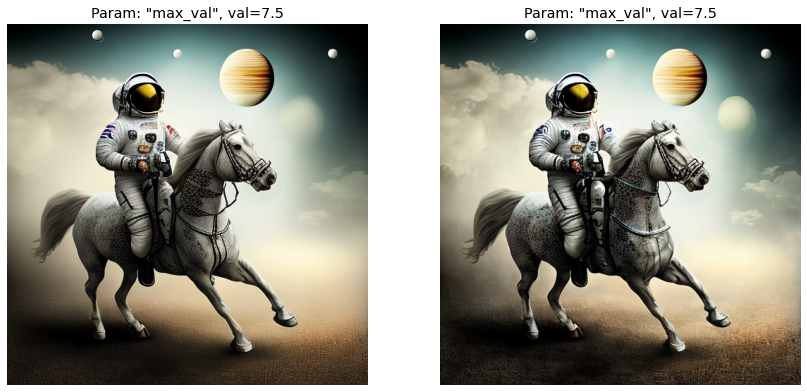

In [ ]:
#| echo: false
#| output: true
image_grid([baseline_res['images'][0], base_norm_res['images'][0]], 
           title=[baseline_res['titles'][0], base_norm_res['titles'][0]],
           rows=1, width=width, height=height)

Comparing left to right, `Prediction Normalization` improves the overall image.  

The horse's body and hair are more defined. The clouds in the background have more texture. The lowest orb in the sky is much better defined. The shadows on the ground also have better coverage and a more natural transition. The ground itself has more details and texture, and is better separated from the background sky.  

Even the reflection on the astronaut's helmet has more depth and looks smoother.  

Overall, it seems that `Prediction Normalization` is a global improvement on the baseline.  

## `T-Norm` results

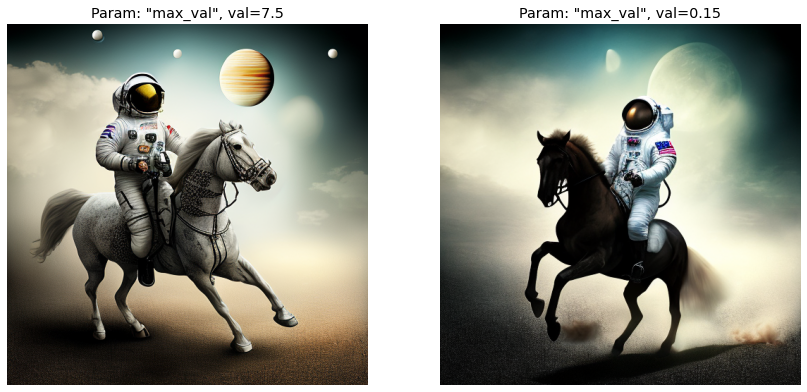

In [ ]:
#| echo: false
#| output: true
image_grid([baseline_res['images'][0], t_norm_res['images'][0]], 
           title=[baseline_res['titles'][0], t_norm_res['titles'][0]],
           rows=1, width=width, height=height)

This one is much more interesting. `T-Normalization` completely changed the image! Even though they started from the exact same noisy latents.  

Here the horse's anatomy, especially its head, look more correct. Even though we lost overall illumination on the horse's body.  

The patches and details on the astronaut's gear are also better defined. And maybe it's subjective, but this one *feels* more like a photograph (thanks to helmet's glare) while the baseline looks more like digital art.  

## `Full Norm` results

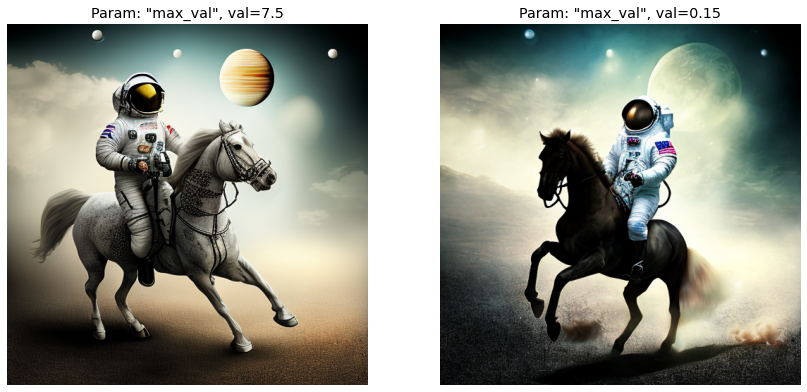

In [ ]:
#| echo: false
#| output: true
image_grid([baseline_res['images'][0], full_norm_res['images'][0]], 
           title=[baseline_res['titles'][0], full_norm_res['titles'][0]],
           rows=1, width=width, height=height)

`Full Normalization` feels like a mix of the best from both worlds.  

The horse's anatomy and astronaut details are better, following the results from `T-Normalization`. And we regained some background vs. foreground separation from `Prediction Normalization`.  

It seems this dual benefit came at the cost of some symmetry for the orbs in the sky, and a loss of resolution on the horse's tail.

## Analysis  

Overall, at least for this example, it is fair to say that normalizations can improve Diffusion images.  

Either the baseline image was improved overall (`Prediction Normalization`), or we gained better image syntax and details (`T-Normalization` and `Full Normalization`).  

Given that `T-Normalization` and `Full Normalization` completely changed the style of the baseline image, there is a lot to explore here. To start, there is likely a much better set of $G_\text{small}$ values. Consider the baseline's value of $G = 7.5$. This value is the standard across many Diffusion models and empirically produces good results. Meanwhile, our $G_\text{small} = 0.15$ is only a starting point that has not been thoroughly tested.  

In summary, it seems that `Prediction Normalization` could be an easy way to improve all Diffusion images. As for the others, they definitely have potential that should be explored further.  

# Conclusion

This notebook was Part 2 in a series on dynamic Classifier-free Guidance.  

We showed that normalizing the guidance has a big impact on the generated images. We found that `Prediction Normalization` has the potential to improve any Diffusion image.  

Now, after Parts 1 and 2, we have a good idea of the guidance schedules and normalizations that might improve generated images.  

In Part 3, we will combine schedules with normalizations to see if their gains compound.  